<img src="./logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales

# Trabajo Práctico Nº8
#### Mathilde d'Hébrail





### Configuracion e inicio de la simulacion

In [61]:
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,5)
import matplotlib.pyplot as plt
import scipy.signal as sg
import warnings
warnings.filterwarnings('ignore')
import math
from scipy.stats import binom
import cmath
import scipy.io as sio
from scipy.io.wavfile import write
import scipy.integrate as integrate
import scipy.special as special
import sounddevice as sd
import pandas as pd
import sympy as sp

# Gráficos interactivos
# %matplotlib ipympl
# Gráficos estáticos
#%matplotlib inline

from pytc2.sistemas_lineales import group_delay, analyze_sys, plot_plantilla
from pytc2.general import print_latex, print_subtitle, a_equal_b_latex_s


#Esto tiene que ver con cuestiones de presentación de los gráficos,
# NO ES IMPORTANTE
fig_sz_x = 14
fig_sz_y = 13
fig_dpi = 80 # dpi
fig_font_size = 16
plt.rcParams.update({'font.size':fig_font_size})

def vertical_flaten(a):

    return a.reshape(a.shape[0], 1)

# ECG

##### Reading the ECG

[('ecg_lead', (1129116, 1), 'double'), ('qrs_pattern1', (113, 1), 'double'), ('heartbeat_pattern1', (411, 1), 'double'), ('heartbeat_pattern2', (441, 1), 'double'), ('qrs_detections', (1903, 1), 'double')]


Text(0.5, 1.0, 'Heartbeat patern 2')

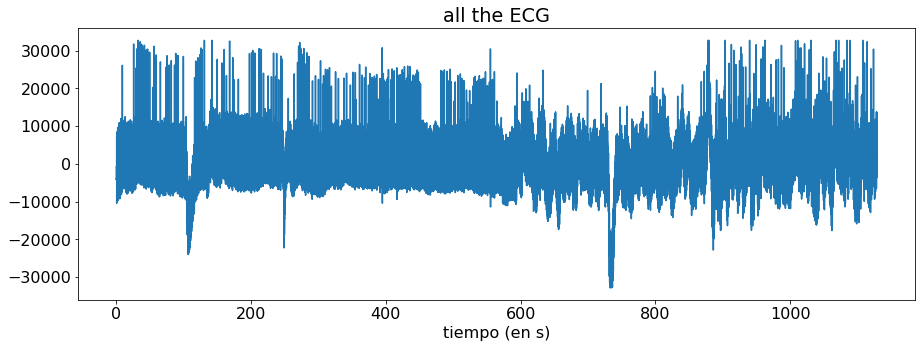

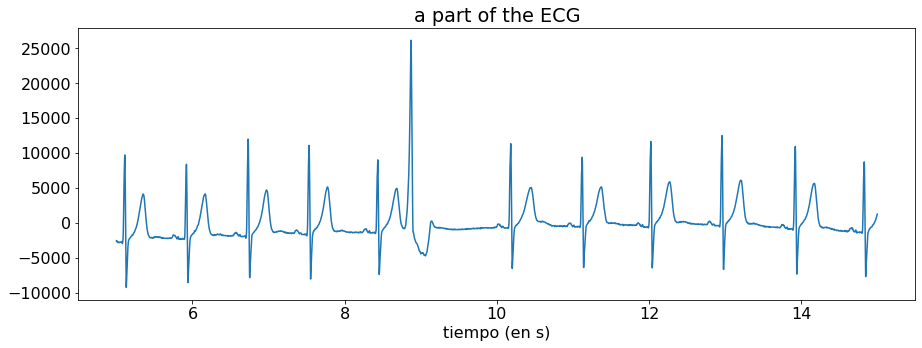

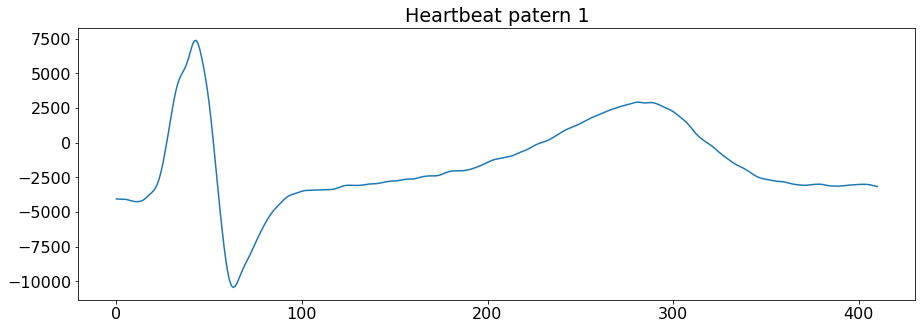

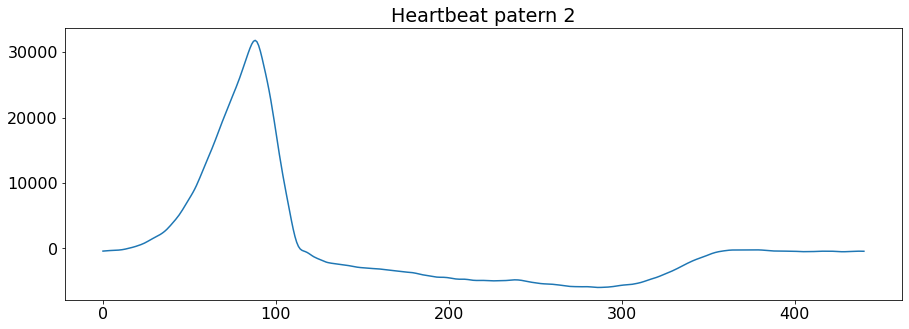

In [62]:
fs_ecg = 1000 # Hz

# para listar las variables que hay en el archivo
print(sio.whosmat('ECG_TP4.mat'))
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_one_lead = vertical_flaten(mat_struct['ecg_lead'])
tt = np.arange(0, len(ecg_one_lead)/fs_ecg, 1/fs_ecg).flatten()

hb_1 = vertical_flaten(mat_struct['heartbeat_pattern1'])
hb_2 = vertical_flaten(mat_struct['heartbeat_pattern2'])

plt.figure(1)
plt.plot(tt, ecg_one_lead)
plt.xlabel("tiempo (en s)")
plt.title("all the ECG")

plt.figure(2)
plt.plot(tt[5000:15000], ecg_one_lead[5000:15000])
plt.xlabel("tiempo (en s)")
plt.title("a part of the ECG")

plt.figure(3)
plt.plot(hb_1)
plt.title("Heartbeat patern 1")

plt.figure(4)
plt.plot(hb_2)
plt.title("Heartbeat patern 2")


In [63]:
data = ecg_one_lead
data = data.flatten()

elMax = max(data)
elMin = min(data)

def normalize(d):
    # d is a (n x dimension) np array
    number = abs(max(d) - min(d))
    d = d/number
    return d

#####  cortar el señal en latidos

In [64]:
cut_points = mat_struct['qrs_detections']
print(mat_struct['qrs_detections'])

[[    482]
 [   1240]
 [   1986]
 ...
 [1127113]
 [1127803]
 [1128482]]


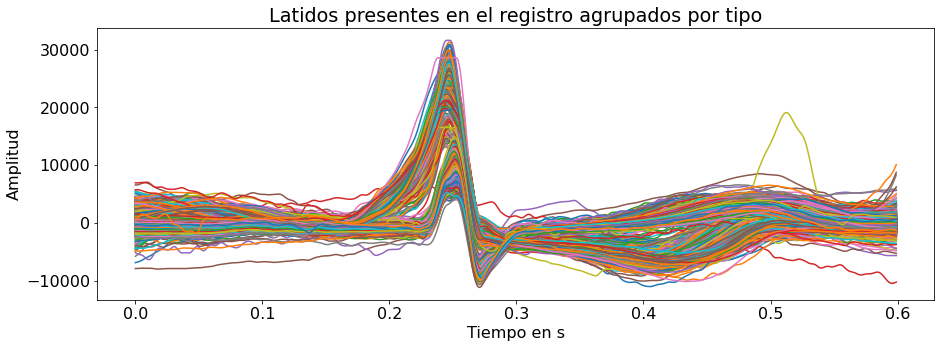

In [65]:
array = []

plt.figure()
for i in range(len(cut_points) - 1):
    segment_start = int(cut_points[i]-250)
    segment_end = int(cut_points[i]+350)
    segment_signal = data[segment_start:segment_end]
    segment_signal = segment_signal - np.mean(segment_signal)
    #segment_signal = normalize(segment_signal)
    array.append(segment_signal)
    
    plt.plot(tt[:600], segment_signal)
    plt.title("Latidos presentes en el registro agrupados por tipo")
    plt.xlabel("Tiempo en s")
    plt.ylabel("Amplitud")

plt.show()

##### Colocar los latidos en un array

In [66]:
array = np.array(array)

In [67]:
print(array[:3])

[[-1854.55666667 -1858.55666667 -1857.55666667 ...  -755.55666667
   -756.55666667  -751.55666667]
 [-1529.985      -1515.985      -1496.985      ... -1022.985
  -1039.985      -1055.985     ]
 [-1538.41       -1544.41       -1540.41       ... -1129.41
  -1121.41       -1116.41      ]]


In [68]:
array_transposed = array.T

##### Calcular y representar el latido promedio

In [69]:
new_ecg = [np.mean(array_transposed[i]) for i in range(len(array_transposed))]
new_ecg_norm = normalize(new_ecg)

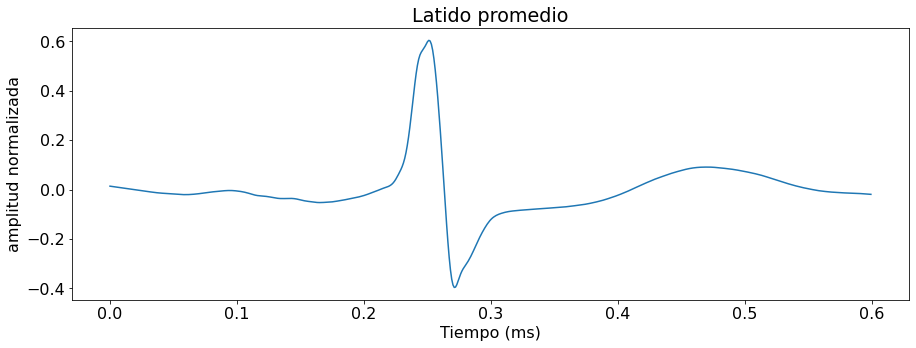

In [70]:
plt.figure
plt.plot(tt[:600],new_ecg_norm)
plt.title("Latido promedio")
plt.xlabel("Tiempo (ms)")
plt.ylabel("amplitud normalizada")
plt.show()

##### DFT de cada latido

In [92]:
df_latido = fs_ecg/600

new_fft = (np.abs((1/600)*np.fft.fft(array, axis = 0)))**2
f, pW = sg.welch(array, fs=fs_ecg, window='hann', nperseg=int(np.round(600/5)), axis = 0)
df_ecg = fs_ecg/10000 # resolución espectral
ff = np.arange(0, fs_ecg//2, df_latido).flatten()

#new_fft = normalize(new_fft)
#new_fft = new_fft - np.mean(new_fft)
print(new_fft[:fs_ecg//2].shape)
print(pW.shape)

(500, 600)
(61, 600)


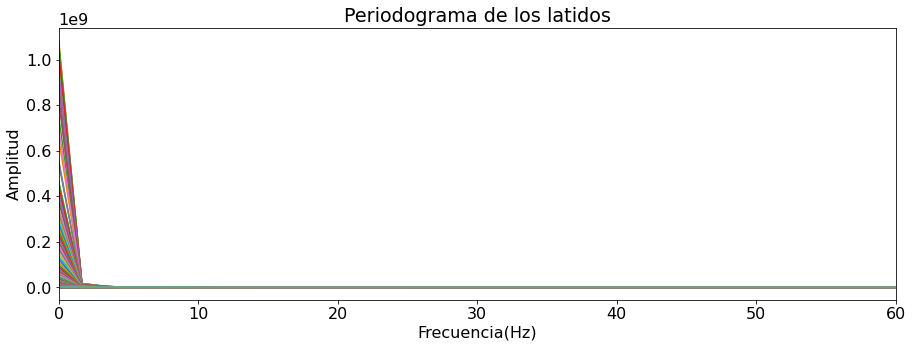

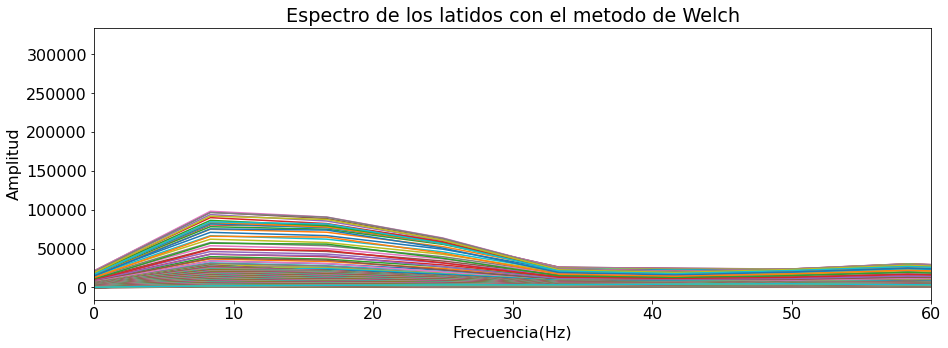

In [94]:
plt.figure
plt.plot(ff, (((new_fft[:len(ff)]))))
plt.title("Periodograma de los latidos")
plt.xlabel("Frecuencia(Hz)")
plt.ylabel("Amplitud")
plt.xlim(0, 60)
plt.show()

plt.figure
plt.plot(f[:fs_ecg//2],((pW[:fs_ecg//2])))
plt.title("Espectro de los latidos con el metodo de Welch")
plt.xlabel("Frecuencia(Hz)")
plt.ylabel("Amplitud")
plt.xlim(0, 60)
plt.show()

## Comparaciones:

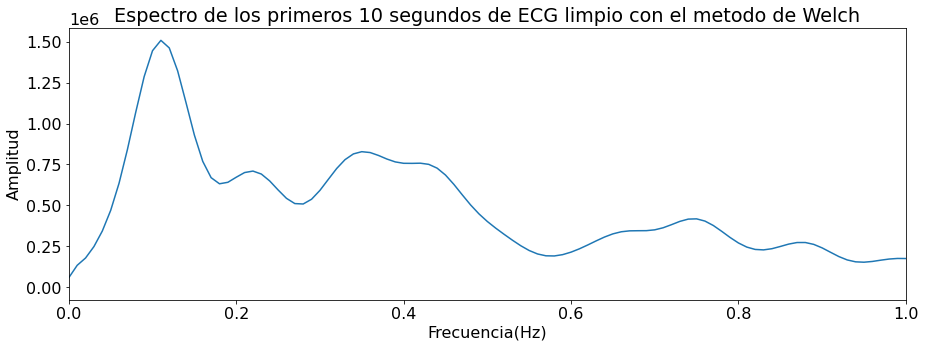

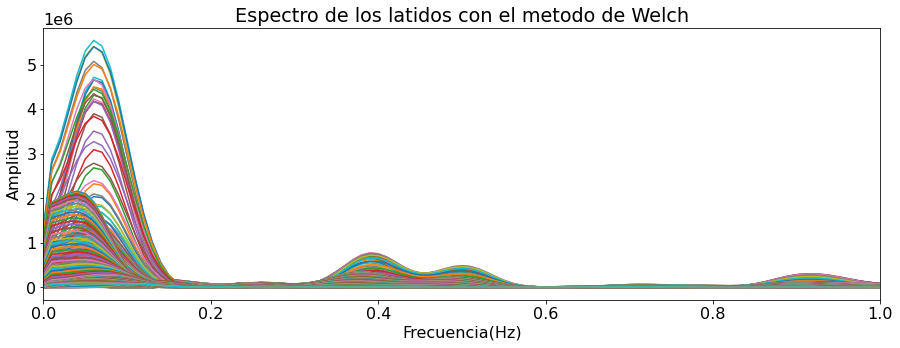

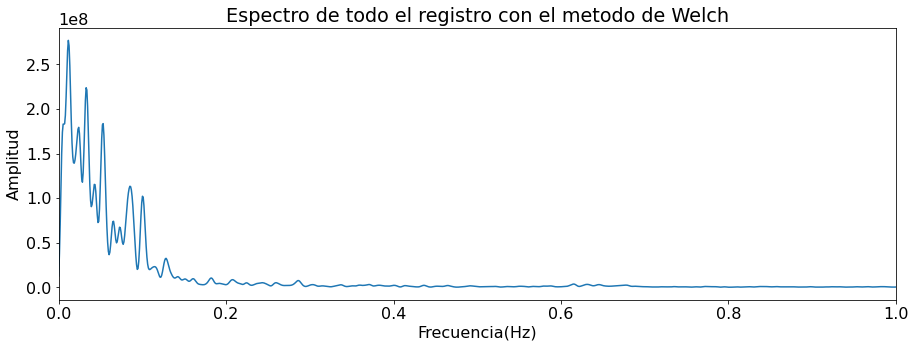

In [73]:
f1, pW1 = sg.welch(data[5000:15000], fs=fs_ecg, window='hann', nfft = 10000, nperseg=int(np.round(10000/5)))
f1 = f1/10

plt.figure
plt.plot(f1,(pW1))
plt.title("Espectro de los primeros 10 segundos de ECG limpio con el metodo de Welch")
plt.xlabel("Frecuencia(Hz)")
plt.ylabel("Amplitud")
plt.xlim(0, 1)
plt.show()


f2, pW2 = sg.welch(array, fs=fs_ecg, window='hann', nfft = 10000, nperseg=int(np.round(10000/5)), axis = 0)
f2 = f2/10

plt.figure
plt.plot(f2,(pW2))
plt.title("Espectro de los latidos con el metodo de Welch")
plt.xlabel("Frecuencia(Hz)")
plt.ylabel("Amplitud")
plt.xlim(0, 1)
plt.show()


f3, pW3 = sg.welch(data, fs=fs_ecg, window='hann', nfft = len(data), nperseg=int(np.round(len(data)/5)))

plt.figure
plt.plot(f3,(pW3))
plt.title("Espectro de todo el registro con el metodo de Welch")
plt.xlabel("Frecuencia(Hz)")
plt.ylabel("Amplitud")
plt.xlim(0, 1)
plt.show()

Observamos que mas largo es el señal, mas alto es su amplitud en frecuencia.  
  
Parece que el espectro de 10 segundos toma en cuenta solamente los latidos normales porque tiene solamente 1 pico afilado que parece al grande pico afilado de los latidos normales de la segunda figura. Esto sesia logico porque en esta secuencia hay solo uno latido ventricular, entonces su frecuencia es nula y baja.  
  
Parce tambien que el espectro de todo el registro toma en cuenta los dos tipos de latidos : el primero pico a la izquierda, mas bajo que el secundo, correspondiente a los latidos ventriculares, que podemos ver en la segunda figura como tambien el primero pico mas bajo. El segundo pico del espectro de todo el ECG, mas alto, seria el de los latidos normales.

# Plantilla de lowpass filter

Vamos a hacer un lowpass filter para que la señal de ECG se asemeje a los latidos promedio en cuanto a suavidad de los trazos. Los ruidos son altas frecuencias, entonces, para eliminarlos, hay que usar un lowpass filter.

In [74]:
# Defina la plantilla del filtro

fs0 = 0.1 # fin de la banda de detenida 0
fc0 = 0.5 # comienzo de la banda de paso
fc1 = 30 # fin de la banda de paso
fs1 = 45 # comienzo de la banda de detenida 1